In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import json
from scipy.stats import ttest_1samp

# Processing data

In [3]:
# Loading data
rca = pd.read_csv('../../data/results/rca_ensemb.csv').dropna()
meta = pd.read_csv('../../data/psychNorms/psychNorms_metadata.csv', index_col=0)

# Adding norm_cat to rca
rca['norm_cat'] = (
    rca['norm'].apply(lambda norm: meta.loc[norm]['category'])
    .replace({'_': ' '}, regex=True)
)

rca

,embed,norm,train_n,fold,r2,mse,check,norm_cat
0,CBOW_GoogleNews,Freq_HAL,9040,1,0.651025,1.130805,pass,frequency
1,CBOW_GoogleNews,Freq_HAL,9040,2,0.663586,1.115586,pass,frequency
2,CBOW_GoogleNews,Freq_HAL,9040,3,0.678476,1.192172,pass,frequency
3,CBOW_GoogleNews,Freq_HAL,9040,4,0.656350,1.167089,pass,frequency
4,CBOW_GoogleNews,Freq_HAL,9040,5,0.680533,1.249321,pass,frequency
...,...,...,...,...,...,...,...,...
7295,fastText_CommonCrawl&PPMI_SVD_SWOW,imageability_fear,510,1,0.667308,0.565868,pass,imageability
7296,fastText_CommonCrawl&PPMI_SVD_SWOW,imageability_fear,510,2,0.640832,0.705835,pass,imageability
7297,fastText_CommonCrawl&PPMI_SVD_SWOW,imageability_fear,510,3,0.592154,0.793009,pass,imageability
7298,fastText_CommonCrawl&PPMI_SVD_SWOW,imageability_fear,510,4,0.539998,0.741900,pass,imageability


In [4]:
rca_mean = (
    rca[['embed', 'norm', 'r2']].groupby(['embed', 'norm'], as_index=False).mean()
    .rename(columns={'r2': 'r2_mean'})
)
rca_mean

,embed,norm,r2_mean
0,CBOW_GoogleNews,Angry_Binder,0.530523
1,CBOW_GoogleNews,AoA_Glasgow,0.603972
2,CBOW_GoogleNews,AoA_Kuper,0.572844
3,CBOW_GoogleNews,AoA_LWV,0.605640
4,CBOW_GoogleNews,Arousal_Binder,0.557260
...,...,...,...
1445,fastText_CommonCrawl&PPMI_SVD_SWOW,valence_janschewitz,0.760608
1446,fastText_CommonCrawl&PPMI_SVD_SWOW,valence_zupan,0.842835
1447,fastText_CommonCrawl&PPMI_SVD_SWOW,visual_complexity_marrow,0.570707
1448,fastText_CommonCrawl&PPMI_SVD_SWOW,visual_lyn,0.597703


In [5]:
rca_mean['norm_cat'] = (
    rca_mean['norm'].apply(lambda norm: meta.loc[norm]['category'])
)
rca_mean

,embed,norm,r2_mean,norm_cat
0,CBOW_GoogleNews,Angry_Binder,0.530523,emotion
1,CBOW_GoogleNews,AoA_Glasgow,0.603972,age_of_acquisition
2,CBOW_GoogleNews,AoA_Kuper,0.572844,age_of_acquisition
3,CBOW_GoogleNews,AoA_LWV,0.605640,age_of_acquisition
4,CBOW_GoogleNews,Arousal_Binder,0.557260,arousal
...,...,...,...,...
1445,fastText_CommonCrawl&PPMI_SVD_SWOW,valence_janschewitz,0.760608,valence
1446,fastText_CommonCrawl&PPMI_SVD_SWOW,valence_zupan,0.842835,valence
1447,fastText_CommonCrawl&PPMI_SVD_SWOW,visual_complexity_marrow,0.570707,sensory
1448,fastText_CommonCrawl&PPMI_SVD_SWOW,visual_lyn,0.597703,sensory


**Grand avgs**

In [6]:
rca_grand_avg = (
    rca_mean[['embed', 'norm_cat', 'r2_mean']]
    .groupby(['embed', 'norm_cat'], as_index=False).median(numeric_only=True)
    .rename(columns={'r2_mean': 'r2_grand_avg'})
)
rca_grand_avg

,embed,norm_cat,r2_grand_avg
0,CBOW_GoogleNews,age_of_acquisition,0.472030
1,CBOW_GoogleNews,animacy,0.705199
2,CBOW_GoogleNews,arousal,0.538374
3,CBOW_GoogleNews,associatability,0.251457
4,CBOW_GoogleNews,autidtory_lexical_decision,0.056433
...,...,...,...
130,fastText_CommonCrawl&PPMI_SVD_SWOW,social/moral,0.744460
131,fastText_CommonCrawl&PPMI_SVD_SWOW,space/time/quantity,0.586526
132,fastText_CommonCrawl&PPMI_SVD_SWOW,this/that,0.526612
133,fastText_CommonCrawl&PPMI_SVD_SWOW,valence,0.767070


In [7]:
with open('../../data/embed_to_dtype.json', 'r') as f:
    embed_to_type = json.load(f)
    
def embed_to_group(embed_name):
    if '&' in embed_name:
        name_1, name_2 = embed_name.split('&')
        return embed_to_type[name_1] + '&' + embed_to_type[name_2]
    else:
        return embed_to_type[embed_name]
    
rca_grand_avg['embed'] = rca_grand_avg['embed'].apply(embed_to_group)
rca_grand_avg = rca_grand_avg.groupby(['embed', 'norm_cat'], as_index=False).mean(numeric_only=True)
rca_grand_avg

,embed,norm_cat,r2_grand_avg
0,text,age_of_acquisition,0.523132
1,text,animacy,0.715979
2,text,arousal,0.541925
3,text,associatability,0.277411
4,text,autidtory_lexical_decision,0.076344
...,...,...,...
76,text&text,social/moral,0.697867
77,text&text,space/time/quantity,0.559473
78,text&text,this/that,0.568573
79,text&text,valence,0.701647


In [8]:
# Top embed_types
sorted_embeds = (
    rca_grand_avg.groupby('embed')['r2_grand_avg']
    .mean()
    .sort_values(ascending=True)
    .reset_index()
)
sorted_embeds

,embed,r2_grand_avg
0,text,0.472181
1,text&text,0.509827
2,text&behavior,0.510155


**grand avg diffs**

In [9]:
# Pivoting to make it easier to compute pairwise differences 
rca_wide = ( 
    rca[['embed', 'norm', 'norm_cat', 'fold', 'r2']]
    .pivot(index=['norm', 'fold', 'norm_cat'], columns='embed', values='r2')
    .reset_index()
)
rca_wide

embed,norm,fold,norm_cat,CBOW_GoogleNews,CBOW_GoogleNews&PPMI_SVD_SWOW,CBOW_GoogleNews&fastText_CommonCrawl,fastText_CommonCrawl,fastText_CommonCrawl&PPMI_SVD_SWOW
0,Angry_Binder,1,emotion,0.451709,0.619194,0.529830,0.581800,0.658787
1,Angry_Binder,2,emotion,0.665374,0.698011,0.697579,0.666636,0.711466
2,Angry_Binder,3,emotion,0.612445,0.636930,0.614584,0.569067,0.593068
3,Angry_Binder,4,emotion,0.546669,0.613367,0.534102,0.439650,0.550141
4,Angry_Binder,5,emotion,0.376419,0.602062,0.466111,0.545599,0.598121
...,...,...,...,...,...,...,...,...
1445,visual_troche,1,sensory,0.774408,0.813753,0.820905,0.796945,0.815251
1446,visual_troche,2,sensory,0.766970,0.726178,0.823857,0.782348,0.792116
1447,visual_troche,3,sensory,0.728596,0.722605,0.771644,0.728382,0.754366
1448,visual_troche,4,sensory,0.796257,0.788990,0.796584,0.762079,0.769485


In [23]:
text_1, text_2 = 'CBOW_GoogleNews', 'fastText_CommonCrawl' # Text
text_text = text_1 + '&' + text_2 # Text & Text 
text_behav_1 = text_1 + '&' + 'PPMI_SVD_SWOW' # Text and Behavior 1
text_behav_2 = text_2 + '&' + 'PPMI_SVD_SWOW' # Text and Behavior 2


# Text & Behavior - Text & Text 
rca_wide[f'{text_behav_1} vs {text_text}'] = rca_wide[text_behav_1] - rca_wide[text_text]
rca_wide[f'{text_behav_2} vs {text_text}'] = rca_wide[text_behav_2] - rca_wide[text_text]
tb_vs_tt = (
    rca_wide[['norm', 'fold', 'norm_cat', f'{text_behav_1} vs {text_text}', f'{text_behav_2} vs {text_text}']]
    .melt(id_vars=['norm', 'norm_cat', 'fold'])
    .rename(columns={'embed': 'comparing'})
)
tb_vs_tt['comparing'] = 'text&behavior - text&text'
tb_vs_tt

,norm,norm_cat,fold,comparing,value
0,Angry_Binder,emotion,1,text&behavior - text&text,0.089364
1,Angry_Binder,emotion,2,text&behavior - text&text,0.000432
2,Angry_Binder,emotion,3,text&behavior - text&text,0.022345
3,Angry_Binder,emotion,4,text&behavior - text&text,0.079265
4,Angry_Binder,emotion,5,text&behavior - text&text,0.135951
...,...,...,...,...,...
2895,visual_troche,sensory,1,text&behavior - text&text,-0.005654
2896,visual_troche,sensory,2,text&behavior - text&text,-0.031742
2897,visual_troche,sensory,3,text&behavior - text&text,-0.017278
2898,visual_troche,sensory,4,text&behavior - text&text,-0.027099


In [24]:
# Text & Behavior - Text
tb_vs_t_cols = []
for text_behav_i in [text_behav_1, text_behav_2]:
    for text_j in [text_1, text_2]:
        comparing = f'{text_behav_i} vs {text_j}'
        rca_wide[comparing] = rca_wide[text_behav_i] - rca_wide[text_j]
        tb_vs_t_cols.append(comparing)
        

tb_vs_t = (
    rca_wide[['norm', 'fold', 'norm_cat'] + tb_vs_t_cols]
    .melt(id_vars=['norm', 'fold', 'norm_cat'])
    .rename(columns={'embed': 'comparing'})
)
tb_vs_t['comparing'] = 'text&behavior - text'

diffs = pd.concat([tb_vs_tt, tb_vs_t])
diffs

,norm,norm_cat,fold,comparing,value
0,Angry_Binder,emotion,1,text&behavior - text&text,0.089364
1,Angry_Binder,emotion,2,text&behavior - text&text,0.000432
2,Angry_Binder,emotion,3,text&behavior - text&text,0.022345
3,Angry_Binder,emotion,4,text&behavior - text&text,0.079265
4,Angry_Binder,emotion,5,text&behavior - text&text,0.135951
...,...,...,...,...,...
5795,visual_troche,sensory,1,text&behavior - text,0.018306
5796,visual_troche,sensory,2,text&behavior - text,0.009768
5797,visual_troche,sensory,3,text&behavior - text,0.025984
5798,visual_troche,sensory,4,text&behavior - text,0.007407


In [25]:
diffs_mean = (
    diffs[['norm', 'comparing', 'value']].groupby(['comparing', 'norm'], as_index=False)
    .mean(numeric_only=True)
    .rename(columns={'value': 'r2_diff'})
)
diffs_mean['norm_cat'] = diffs_mean['norm'].apply(lambda norm: meta.loc[norm]['category'])
diffs_mean

,comparing,norm,r2_diff,norm_cat
0,text&behavior - text,Angry_Binder,0.082578,emotion
1,text&behavior - text,AoA_Glasgow,0.038088,age_of_acquisition
2,text&behavior - text,AoA_Kuper,0.047512,age_of_acquisition
3,text&behavior - text,AoA_LWV,0.045380,age_of_acquisition
4,text&behavior - text,Arousal_Binder,0.094774,arousal
...,...,...,...,...
575,text&behavior - text&text,valence_janschewitz,0.050194,valence
576,text&behavior - text&text,valence_zupan,0.026584,valence
577,text&behavior - text&text,visual_complexity_marrow,0.017587,sensory
578,text&behavior - text&text,visual_lyn,0.024201,sensory


In [26]:
diffs_grand_avg = (
    diffs_mean.groupby(['comparing', 'norm_cat'], as_index=False)
    .median(numeric_only=True)
    .rename(columns={'r2_diff': 'r2_diff_grand_avg'})
)
diffs_grand_avg

,comparing,norm_cat,r2_diff_grand_avg
0,text&behavior - text,age_of_acquisition,0.013788
1,text&behavior - text,animacy,0.018895
2,text&behavior - text,arousal,0.094774
3,text&behavior - text,associatability,0.052593
4,text&behavior - text,autidtory_lexical_decision,-0.002264
5,text&behavior - text,concreteness,0.036819
6,text&behavior - text,dominance,0.119729
7,text&behavior - text,emotion,0.072674
8,text&behavior - text,familiarity,0.005155
9,text&behavior - text,frequency,0.040272


## Plotting 

In [27]:
# Pivot rca_grand_avg for plotting
heat_df_1 = (
    rca_grand_avg
    .pivot(index='embed', columns='norm_cat', values='r2_grand_avg')
    .loc[['text', 'text&text', 'text&behavior']]
)

# Ordering norm_cats by text&behavior performance
norm_cat_order = heat_df_1.loc['text&behavior'].sort_values(ascending=True).index
heat_df_1 = heat_df_1[norm_cat_order]
heat_df_1.index = heat_df_1.index.str.replace('&', ' & ').str.title()
heat_df_1.columns = heat_df_1.columns.str.replace('_', ' ')
heat_df_1

norm_cat,autidtory lexical decision,semantic decision,number of features,naming,semantic neighborhood,familiarity,associatability,iconicity/transparency,visual lexical decision,recognition memory,...,arousal,sensory,dominance,part of speech,semantic diversity,animacy,social/moral,concreteness,valence,frequency
embed,,,,,,,,,,,,,,,,,,,,,
Text,0.076344,0.192249,0.182840,0.195218,0.203619,0.300782,0.277411,0.316731,0.329972,0.394782,...,0.541925,0.599171,0.525418,0.694902,0.699044,0.715979,0.662273,0.754404,0.662975,0.730351
Text & Text,0.090991,0.207838,0.197587,0.231457,0.235750,0.355254,0.313878,0.333040,0.396034,0.411289,...,0.599780,0.637093,0.566376,0.724481,0.736929,0.753377,0.697867,0.784888,0.701647,0.813058
Text & Behavior,0.072493,0.158646,0.195060,0.199273,0.220150,0.303848,0.330004,0.342987,0.344748,0.409774,...,0.647832,0.650917,0.660597,0.697626,0.713732,0.732823,0.737773,0.764809,0.766568,0.773844


In [28]:
rca_winners_bool = heat_df_1.apply(lambda col: col == col.max(), axis=0)
rca_winners_bool

norm_cat,autidtory lexical decision,semantic decision,number of features,naming,semantic neighborhood,familiarity,associatability,iconicity/transparency,visual lexical decision,recognition memory,...,arousal,sensory,dominance,part of speech,semantic diversity,animacy,social/moral,concreteness,valence,frequency
embed,,,,,,,,,,,,,,,,,,,,,
Text,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Text & Text,True,True,True,True,True,True,False,False,True,True,...,False,False,False,True,True,True,False,True,False,True
Text & Behavior,False,False,False,False,False,False,True,True,False,False,...,True,True,True,False,False,False,True,False,True,False


In [29]:
# Pivot diffs_grand_avg for plotting
diffs_grand_avg = (
    diffs_grand_avg
    .pivot(index='comparing', columns='norm_cat', values='r2_diff_grand_avg')
)
diffs_grand_avg = diffs_grand_avg[norm_cat_order]
diffs_grand_avg.index = diffs_grand_avg.index.str.replace('&', ' & ').str.title()
diffs_grand_avg.columns = diffs_grand_avg.columns.str.replace('_', ' ')
diffs_grand_avg

norm_cat,autidtory lexical decision,semantic decision,number of features,naming,semantic neighborhood,familiarity,associatability,iconicity/transparency,visual lexical decision,recognition memory,...,arousal,sensory,dominance,part of speech,semantic diversity,animacy,social/moral,concreteness,valence,frequency
comparing,,,,,,,,,,,,,,,,,,,,,
Text & Behavior - Text,-0.002264,-0.002776,0.012220,0.004055,0.027468,0.005155,0.052593,0.005248,0.011041,0.014993,...,0.094774,0.040552,0.119729,0.002723,0.027143,0.018895,0.064801,0.036819,0.092115,0.040272
Text & Behavior - Text & Text,-0.018498,-0.030622,-0.002527,-0.032183,-0.017513,-0.037907,0.016126,0.002577,-0.056571,-0.001515,...,0.068883,0.006752,0.079527,-0.026855,-0.040667,-0.008076,0.034867,-0.008090,0.051195,-0.036903


In [30]:
heat_df_2 = pd.DataFrame(diffs_grand_avg.loc['Text & Behavior - Text']).T
heat_df_3 = pd.DataFrame(diffs_grand_avg.loc['Text & Behavior - Text & Text']).T
heat_df_3

norm_cat,autidtory lexical decision,semantic decision,number of features,naming,semantic neighborhood,familiarity,associatability,iconicity/transparency,visual lexical decision,recognition memory,...,arousal,sensory,dominance,part of speech,semantic diversity,animacy,social/moral,concreteness,valence,frequency
Text & Behavior - Text & Text,-0.018498,-0.030622,-0.002527,-0.032183,-0.017513,-0.037907,0.016126,0.002577,-0.056571,-0.001515,...,0.068883,0.006752,0.079527,-0.026855,-0.040667,-0.008076,0.034867,-0.00809,0.051195,-0.036903


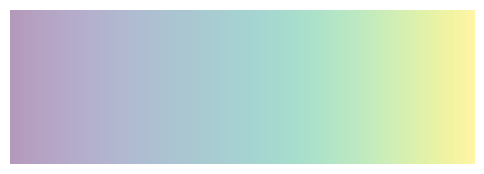

In [31]:
def lighten_cmap(cmap, factor=0.3):
    cmap = plt.cm.get_cmap(cmap, 256)  # Get the original colormap
    colors = cmap(np.linspace(0, 1, 256))

    # Blend each color with white by adjusting RGB values
    white = np.array([1, 1, 1, 1])  # RGBA for white
    new_colors = (1 - factor) * colors + factor * white

    return LinearSegmentedColormap.from_list('lighter_' + cmap.name, new_colors)


def plot_colormap(cmap):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    fig, ax = plt.subplots(figsize=(6, 2))
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.set_axis_off()
    plt.show()


# Custom colormap: viridis with white added
viridis = plt.cm.get_cmap('viridis', 256)
new_colors = viridis(np.linspace(0, 1, 256))

# Modify the first 30% of the colormap to blend with white
new_colors[:50, :] = [1, 1, 1, 1]  # Setting white for the first 50 values
custom_cmap = LinearSegmentedColormap.from_list('viridis_white', new_colors)

# Generate a lighter version of viridis
lighter_viridis = lighten_cmap('viridis', factor=0.6)  # factor closer to 1 means lighter

# Visualize the lighter viridis colormap
plot_colormap(lighter_viridis)

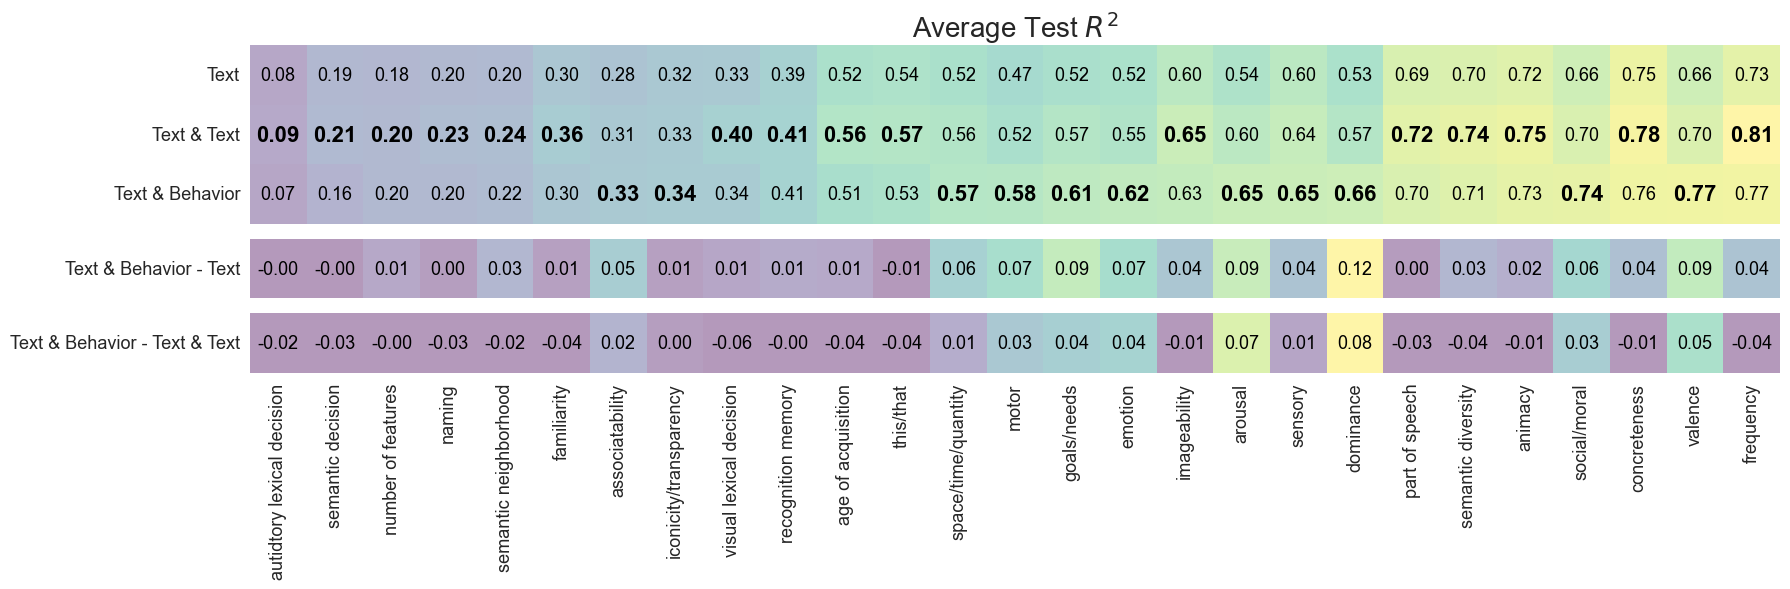

In [32]:
def annotate(heat_df, ax, winners_bool=None):
    for x, norm_cat in enumerate(heat_df.columns):
        for y, embed in enumerate(heat_df.index):
            annot = heat_df.loc[embed, norm_cat]
            
            # Scientific notation
            if abs(annot) > 1e3:
                annot = f'{annot:.1e}'
            elif np.isnan(annot):
                annot = ''
            else:
                annot = f'{annot:.2f}'
            
            # Fontsize and fontweight
            fontsize, fontweight = 13, 'normal'
            if winners_bool is not None:
                if winners_bool.loc[embed, norm_cat]:
                    fontsize, fontweight = 16, 'bold' 
            
            ax.text(
                x + .5, y + .5, annot, fontsize=fontsize, fontweight=fontweight,
                ha='center', va='center', color='black'
            )

heat_dfs = [heat_df_1, heat_df_2, heat_df_3]
fig, axs = plt.subplots(3, figsize=(18, 6), height_ratios=[len(df) for df in heat_dfs])

# Plotting grand avg
vmax = heat_df_1.max().max()
sns.heatmap(
    heat_df_1, vmin=0, cmap=lighter_viridis, 
    vmax=vmax, annot=False, fmt='', cbar=False,
    ax=axs[0]
)

# Plotting text & behavior - text
vmax = heat_df_2.max().max()
sns.heatmap(
    heat_df_2, cmap=lighter_viridis,
    vmin=0, vmax=vmax, annot=False, fmt='', cbar=False,
    ax=axs[1]
)

# Plotting text & behavior - text & text
vmax = heat_df_3.max().max()
sns.heatmap(
    heat_df_3, cmap=lighter_viridis,
    vmin=0, vmax=vmax, annot=False, fmt='', cbar=False,
    ax=axs[2]
)

for ax in axs:
    ax.set(xlabel='', ylabel='')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
    
    # rotates y-tick labels to horizontal
    plt.setp(ax.get_yticklabels(), rotation=0)

# Remove x-tick labels for all but last plot
for ax in axs[:-1]:
    ax.set_xticklabels([])

# Annotates cells
annotate(heat_df_1, axs[0], rca_winners_bool)
annotate(heat_df_2, axs[1])
annotate(heat_df_3, axs[2])

# Sets axis titles
axs[0].set_title('Average Test $R^2$', fontsize=20)
  
fig.tight_layout()
plt.savefig('../../figures/rca_ensemb.png', dpi=300, bbox_inches='tight')

## Paper Stats
To do: 
1. wilcoxin instead of t? 

In [33]:
tb_vs_tt_fold_mean = tb_vs_tt.groupby

,norm,norm_cat,fold,comparing,value
0,Angry_Binder,emotion,1,text&behavior - text&text,0.089364
1,Angry_Binder,emotion,2,text&behavior - text&text,0.000432
2,Angry_Binder,emotion,3,text&behavior - text&text,0.022345
3,Angry_Binder,emotion,4,text&behavior - text&text,0.079265
4,Angry_Binder,emotion,5,text&behavior - text&text,0.135951
...,...,...,...,...,...
2895,visual_troche,sensory,1,text&behavior - text&text,-0.005654
2896,visual_troche,sensory,2,text&behavior - text&text,-0.031742
2897,visual_troche,sensory,3,text&behavior - text&text,-0.017278
2898,visual_troche,sensory,4,text&behavior - text&text,-0.027099


valence diffs: 


/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_16873/806157460.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()['value']


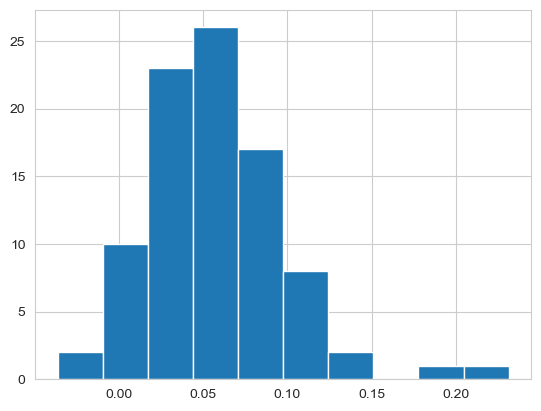

{'cat': 'valence', 'mean': 0.06, 'n': 90, 't': 13.99, 'p': 3.398866266756882e-24}
dominance diffs: 


/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_16873/806157460.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()['value']


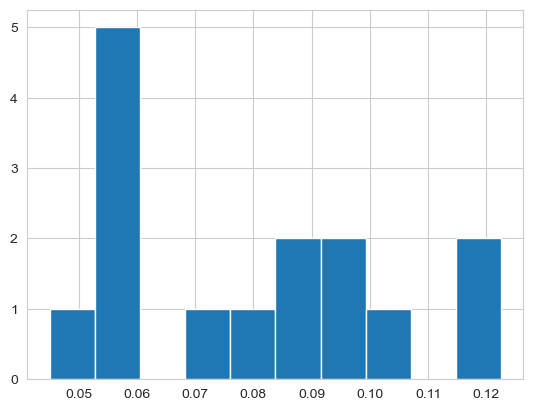

/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_16873/806157460.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()['value']


{'cat': 'dominance', 'mean': 0.08, 'n': 15, 't': 12.79, 'p': 4.1235090921670604e-09}
arousal diffs: 


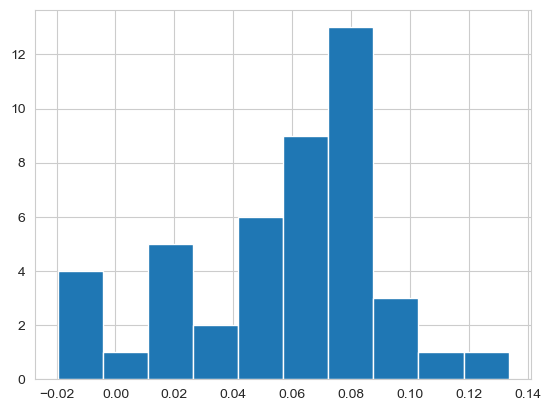

{'cat': 'arousal', 'mean': 0.06, 'n': 45, 't': 11.2, 'p': 1.8133456503144977e-14}
emotion diffs: 


/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_16873/806157460.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()['value']


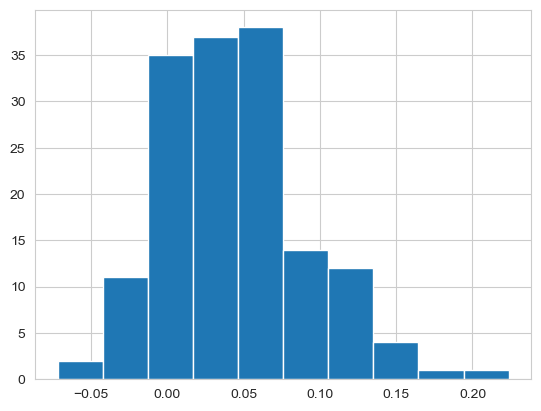

{'cat': 'emotion', 'mean': 0.04, 'n': 155, 't': 11.56, 'p': 1.2244870804072783e-22}
------------------------
goals/needs diffs: 


/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_16873/806157460.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()['value']


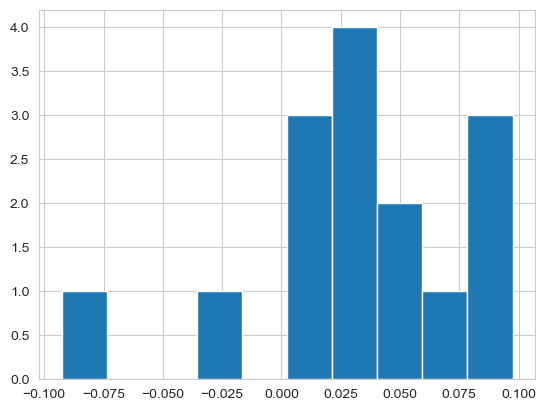

{'cat': 'goals/needs', 'mean': 0.03, 'n': 15, 't': 2.61, 'p': 0.02037601558852027}
motor diffs: 


/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_16873/806157460.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()['value']


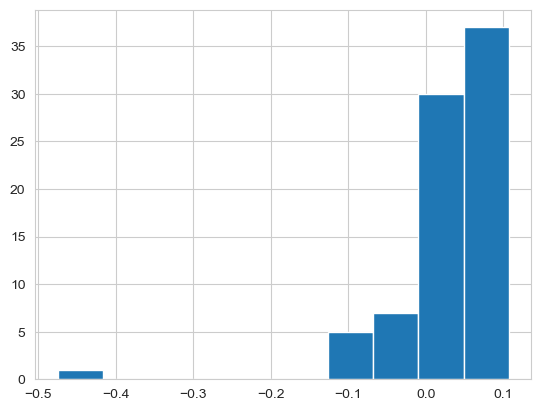

{'cat': 'motor', 'mean': 0.03, 'n': 80, 't': 3.15, 'p': 0.0023033439775872818}
------------------------
social/moral diffs: 


/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_16873/806157460.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()['value']


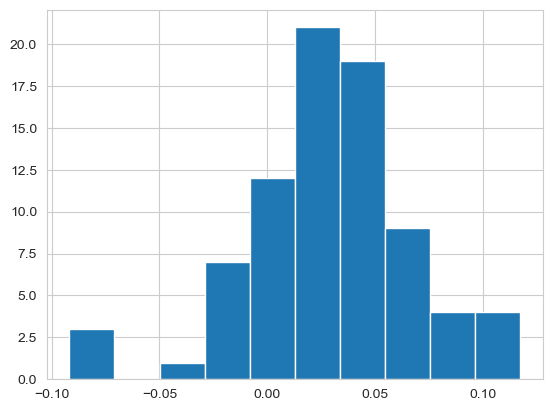

{'cat': 'social/moral', 'mean': 0.03, 'n': 80, 't': 6.64, 'p': 3.636369032129488e-09}
------------------------
part of speech diffs: 


/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_16873/806157460.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()['value']


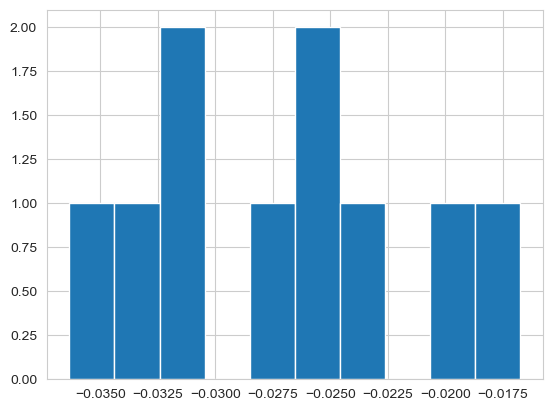

{'cat': 'part of speech', 'mean': -0.03, 'n': 10, 't': -13.83, 'p': 2.2755373049193334e-07}
semantic diversity diffs: 


/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_16873/806157460.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()['value']


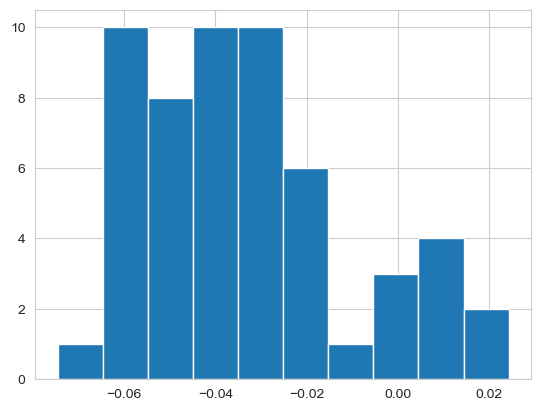

{'cat': 'semantic diversity', 'mean': -0.03, 'n': 55, 't': -10.97, 'p': 2.3343822742913953e-15}
familiarity diffs: 


/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_16873/806157460.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()['value']


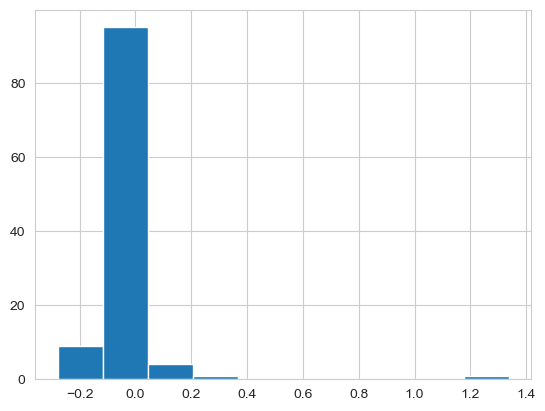

{'cat': 'familiarity', 'mean': -0.02, 'n': 110, 't': -1.66, 'p': 0.09960494263363459}


In [34]:
def diff_stats(norm_cat):
    # Averaging diffs across folds
    diffs = (
        tb_vs_tt.query(f'norm_cat == "{norm_cat}"')
        .groupby(['norm', 'fold'])
        .mean()['value']
    )

    # Printing histogram of diffs
    print(f'{norm_cat} diffs: ')
    diffs.hist()
    plt.show()

    t, p = ttest_1samp(diffs, 0)
    return {
        'cat': norm_cat, 'mean': diffs.mean().round(2), 
        'n': len(diffs),'t': round(t, 2), 'p': p}

# Text & Behavior > Text & Text
print(diff_stats('valence'))
print(diff_stats('dominance'))
print(diff_stats('arousal'))
print(diff_stats('emotion'))
print('------------------------')
print(diff_stats('goals/needs'))
print(diff_stats('motor'))
print('------------------------')
print(diff_stats('social/moral'))

# Text & Behavior < Text & Text
print('------------------------')
print(diff_stats('part of speech'))
print(diff_stats('semantic diversity'))
print(diff_stats('familiarity'))